In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import invgamma
from geopy.distance import geodesic
from dms_variants.ispline import Isplines, Isplines_total
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
import pymc as pm
import sys

# Add the module path to sys.path
sys.path.append('../../')

In [2]:
#----------------------------------------------------------------
# load in and parse data
#----------------------------------------------------------------

# dat_all = pd.read_csv("../../data/sa_family_data.csv").sample(n=20,random_state=1)
dat_all = pd.read_csv("../../data/sa_family_data.csv")

# Parse data into location, environmental variables, and species cover/presence
location_mat = dat_all[['latitude', 'longitude']].values
env_var_names = ['gmap', 'RFL_CONC', 'Elevation30m', 'HeatLoadIndex30m', 'tmean13c', 'SoilConductivitymSm', 'SoilTotalNPercent']
envr_use = dat_all[['gmap', 'RFL_CONC', 'Elevation30m', 'HeatLoadIndex30m', 'tmean13c', 'SoilConductivitymSm', 'SoilTotalNPercent']].values
species_mat = dat_all.iloc[:, 12:].values

location_mat_R = pd.read_csv("CSV-comparisons/location_mat_R.csv")
envr_use_R = pd.read_csv("CSV-comparisons/envr_use_R.csv")
species_mat_R = pd.read_csv("CSV-comparisons/species_mat_R.csv")


In [3]:
# Check if the location_mat variable is equal to the latitude and longitude columns of location_mat_R
location_check = np.all(location_mat == location_mat_R[['latitude', 'longitude']].values)
print(f"Location matrix check: {location_check}")
# Explanation: This checks if the location_mat variable is equal to the latitude and longitude columns of location_mat_R. It returns True if they are equal, and False otherwise.

# Check if the envr_use variable is equal to the values of envr_use_R
envr_use_check = np.all(envr_use == envr_use_R.values)
print(f"Environmental use matrix check: {envr_use_check}")
# Explanation: This checks if the envr_use variable is equal to the values of envr_use_R. It returns True if they are equal, and False otherwise.

# Check if the species_mat variable is equal to the values of species_mat_R
species_mat_check = np.all(species_mat == species_mat_R.values)
print(f"Species matrix check: {species_mat_check}")
# Explanation: This checks if the species_mat variable is equal to the values of species_mat_R. It returns True if they are equal, and False otherwise.

Location matrix check: True
Environmental use matrix check: True
Species matrix check: True


In [4]:
# Get the number of sites
ns = location_mat.shape[0]

#----------------------------------------------------------------
# Calculate Bray-Curtis dissimilarity -- see proportion of 0's and 1's
#----------------------------------------------------------------

# Define dissimilarity metric
diss_met = 'braycurtis'

# Create pair-wise response matrix. pdist outputs a 1D matrix
Z = pdist(species_mat, diss_met)

# Find indices for observations with dissimilarity of exactly 1
Z_is_one = np.where(Z == 1)[0]
Z_is_not_one = np.where(Z != 1)[0]

# Get counts
n1 = len(Z_is_one)
N = len(Z)

# Print the proportion of zeros and ones in the diinternal_knots = knots(I_splines_x)ssimilarity matrix
print(f"Proportion of zeros: {np.mean(Z == 0)}")
print(f"Proportion of ones: {np.mean(Z == 1)}")



Proportion of zeros: 0.0
Proportion of ones: 0.04584028773595994


In [5]:
Z_R = pd.read_csv("CSV-comparisons/Z_R.csv")

# Check if the Z variable is equal to the values of Z_R
Z_check = np.allclose(Z, Z_R.values.reshape(-1), atol=1e-5)
print(f"Dissimilarity matrix check: {Z_check}")
# Explanation: This checks if the Z variable is equal to the values of Z_R. It returns True if they are equal, and False otherwise.

Dissimilarity matrix check: True


In [16]:
#----------------------------------------------------------------
# Define covariates that will be warped by I-spline function AND coefficients
#----------------------------------------------------------------

# Calculate pairwise geographical distance in km using geodesic with WGS84 in vector form (upper triangle of matrix)
vec_distance = pdist(location_mat, lambda lat, lon: geodesic(lat, lon).kilometers)

# Define a (sub)set of environmental variables to be used as covariates
X = envr_use[:, [0, 1, 2, 3, 4, 5, 6]]

# How many knots do you want? What is the degree of the spline?
# Remember that in the specification, of the iSpline that the degree is
# one higher that what you say. Integration of m-spline adds one degree.
# Define the degree and number of knots for the I-spline basis
deg = 3
knots = 2
order = deg + 1
df = deg + knots

# TODO - Double check understanding of the order and degrees. Previously I used the order in the ISpline function call.

# Create ISpline bases, with different range (i.e. mesh) for each variable. Note NO extrapolation with this method, only interpolation.
I_spline_bases = np.column_stack([
    Isplines(deg, [X[:,i].min(), X[:,i].min() + (X[:,i].max() - X[:,i].min())/3, X[:,i].min() + (X[:,i].max() - X[:,i].min())*2/3, X[:,i].max()], X[:,i]).I(j) 
    for i in range(X.shape[1]) 
    for j in range(1,df+1)])

# Pairwise differences of each basis function in a vector. Shape ns**2 / 2 x p * df
I_spline_bases_diffs = np.array([pdist(I_spline_bases[:, i].reshape(-1, 1), metric='euclidean') for i in range(I_spline_bases.shape[1])]).T

# Create spline for the geodesic distances
dist_mesh = [vec_distance.min(), vec_distance.min() + (vec_distance.max() - vec_distance.min())/3, vec_distance.min() + (vec_distance.max() - vec_distance.min())*2/3, vec_distance.max()]
dist_splines = np.column_stack([Isplines(deg, dist_mesh, vec_distance).I(i) for i in range(1, df+1)])

# Combine the I-spline bases and the geographical distances
X_GDM = np.column_stack([I_spline_bases_diffs, dist_splines])

# Name columns
column_names = [f"{var}_I{j}" for var in env_var_names for j in range(1, df+1)] + [f"Dist_I{j}" for j in range(1, df+1)]
X_GDM_df = pd.DataFrame(X_GDM, columns=column_names)
p = X_GDM.shape[1]

# Get row and column indices for each dissimilarity 
row_ind, col_ind = np.triu_indices(ns, k=1)

# Check for linearly generated data what the splines look like

x check: True
I_splines_x check: True


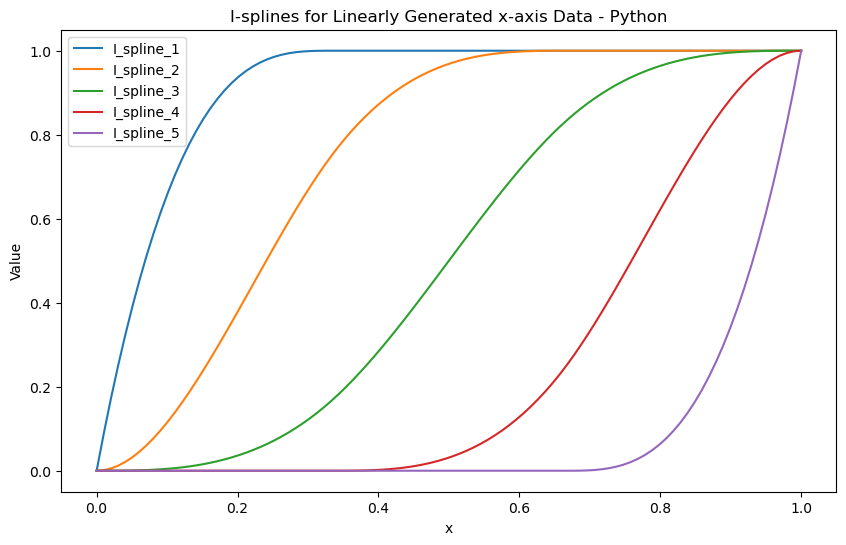

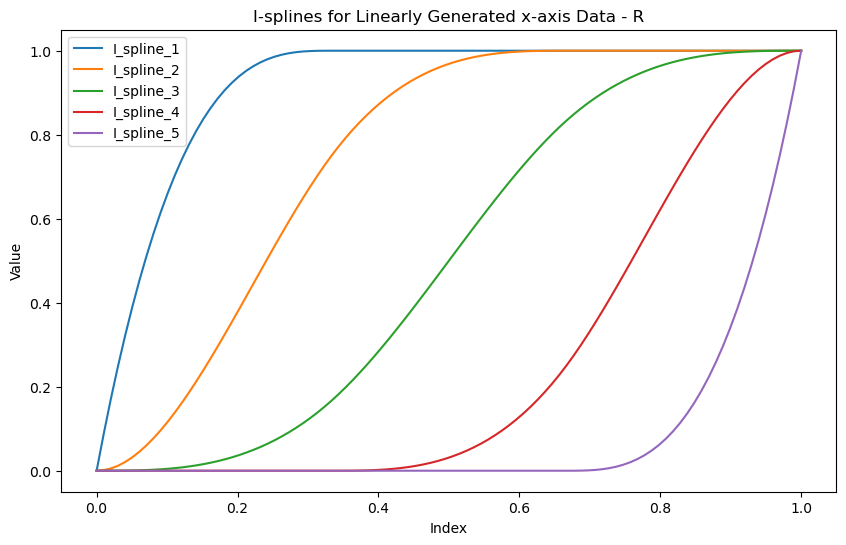

In [94]:
import pandas as pd

# Plotting the I-splines for linearly generated x-axis data
x = np.linspace(0, 1, 100)

deg = 3
knots = 2
order = deg + 1
df = deg + knots

I_splines_x = np.column_stack([Isplines(deg, [x.min(), x.min() + (x.max() - x.min())/3, x.min() + (x.max() - x.min())*2/3, x.max()], x).I(j) for j in range(1,df+1)])
I_splines_x_R = pd.read_csv("CSV-comparisons/I_splines_x_R.csv")

import matplotlib.pyplot as plt

# Check if inputs are the same: x and x_R
x_R = pd.read_csv("CSV-comparisons/x_R.csv")
x_check = np.allclose(x, x_R.values.reshape(-1))
print(f"x check: {x_check}")

# Check if output is the same: I_splines_x is equal to I_splines_x_R
I_splines_x_check = np.allclose(I_splines_x, I_splines_x_R.values, atol=1e-5)
print(f"I_splines_x check: {I_splines_x_check}")

# Plot the I-splines for linearly generated x-axis data - Python
plt.figure(figsize=(10, 6))
for i in range(I_splines_x.shape[1]):
    plt.plot(x, I_splines_x[:, i], label=f'I_spline_{i+1}')
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.title('I-splines for Linearly Generated x-axis Data - Python')
plt.show()

# For R
plt.figure(figsize=(10, 6))
for i in range(I_splines_x_R.shape[1]):
    plt.plot(x, I_splines_x_R.values[:, i], label=f'I_spline_{i+1}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('I-splines for Linearly Generated x-axis Data - R')
plt.show()

# I_splines_x_df = pd.DataFrame(I_splines_x, columns=[f"iSpline(x, degree = 2, df = 5, intercept = TRUE){i+1}" for i in range(df)])
# print(I_splines_x_df.describe())
# I_splines_x_R.describe()

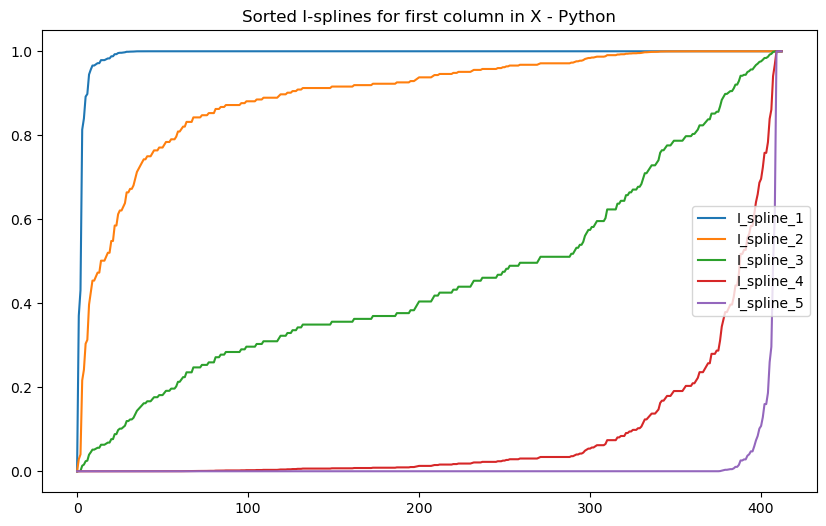

True

In [68]:
x = X[:,0]

I_splines_first_col = np.column_stack([Isplines(deg, [x.min(), x.min() + (x.max() - x.min())/3, x.min() + (x.max() - x.min())*2/3, x.max()], x).I(j) for j in range(1,df+1)])

# Plot the sorted I-splines for linearly generated x-axis data - Python
plt.figure(figsize=(10, 6))
for i in range(I_splines_first_col.shape[1]):
    sorted_values = np.sort(I_splines_first_col[:, i], axis=0)
    plt.plot(range(len(sorted_values)), sorted_values, label=f'I_spline_{i+1}')
plt.title('Sorted I-splines for first column in X - Python')
plt.legend()
plt.show()

np.allclose(I_splines_first_col, I_spline_bases[:,:5])

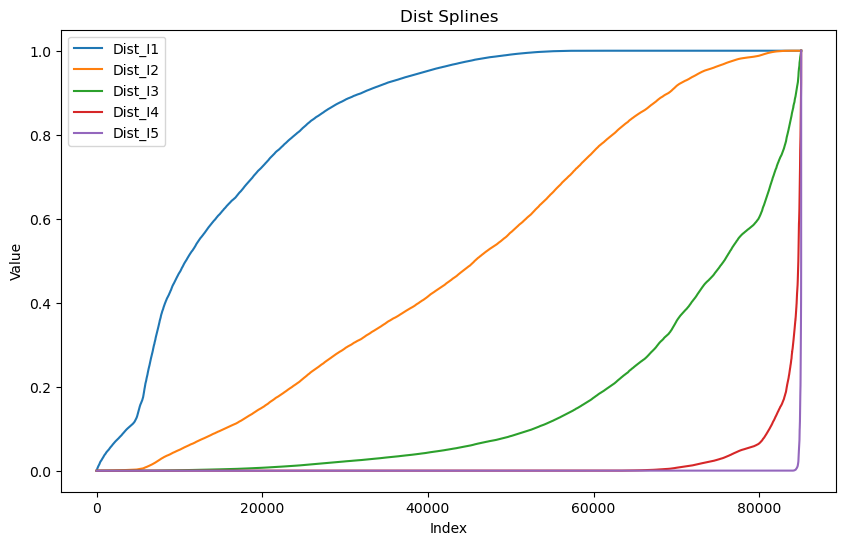

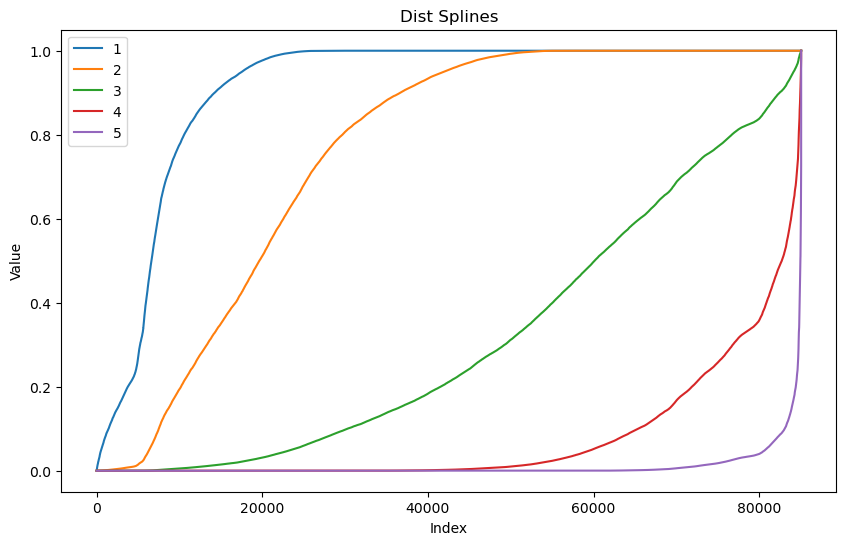

In [21]:
# TODO: Check the bases are the same. They should be almost identical.

X_R = pd.read_csv("CSV-comparisons/X_R.csv")

np.all(X == X_R)

dist_splines_R = pd.read_csv("CSV-comparisons/dist_splines_R.csv")

dist_splines_df = pd.DataFrame(dist_splines, columns=[f"Dist_I{j}" for j in range(1, df+1)])

# Plot the data
plt.figure(figsize=(10, 6))
for column in dist_splines_df.columns:
    sorted_values = np.sort(dist_splines_df[column])
    plt.plot(range(len(sorted_values)), sorted_values, label=column)
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('Dist Splines')
plt.show()

# Plot the data
plt.figure(figsize=(10, 6))
for column in dist_splines_R.columns:
    sorted_values = np.sort(dist_splines_R[column])
    plt.plot(range(len(sorted_values)), sorted_values, label=column)
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('Dist Splines')
plt.show()

In [25]:
vec_distance_R = pd.read_csv("CSV-comparisons/vec_distance_R.csv")

# Check if vec_distance is equal to vec_distance_R
vec_distance_check = np.allclose(vec_distance, vec_distance_R.values.reshape(-1), atol=1e-5)
print(f"vec_distance check: {vec_distance_check}")

I_spline_bases_R = pd.read_csv("CSV-comparisons/I_spline_bases_R.csv")
X_GDM_R = pd.read_csv("CSV-comparisons/X_GDM_R.csv")

# Check if I_spline_bases is equal to I_spline_bases_R
I_spline_bases_check = np.allclose(I_spline_bases, I_spline_bases_R.values, atol=1e-5)
print(f"I_spline_bases check: {I_spline_bases_check}")

vec_distance check: True
I_spline_bases check: False


#  Plotting the I_Spline bases matrices for python and R

In [99]:
import pandas as pd

# Inputs to python I spline bases
# X but this is confirmed equal to X_R
print(np.all(X == X_R))
# Spline creation function. deg = 3, df + 1 = 6
# Confirmed equal production from x linearly spaced from 0 to 1

# Inputs to R I spline bases
# X_R confirmed equal to X
# Created

X_df = pd.DataFrame(X, columns=[f"Feature_{i+1}" for i in range(X.shape[1])])
print(X_df.describe())
print("--------------------\n")
print(X_R.describe())

# I believe it is a problem with the R implementation of the I-splines. The values are not the same as the Python implementation. Maybe something to do with how it figures out the boundary notes etc

True
        Feature_1   Feature_2    Feature_3   Feature_4   Feature_5  \
count  413.000000  413.000000   413.000000  413.000000  413.000000   
mean   224.605327   28.910896  1008.796610  213.489104   16.093463   
std     47.033624    9.757763   359.835038   12.034255    2.038663   
min     72.000000    6.900000   184.000000  120.000000   11.800000   
25%    200.000000   22.700000   756.000000  210.000000   14.600000   
50%    216.000000   30.100000  1078.000000  215.000000   15.900000   
75%    244.000000   31.200000  1235.000000  219.000000   17.299999   
max    387.000000   51.500000  1652.000000  244.000000   20.500000   

        Feature_6   Feature_7  
count  413.000000  413.000000  
mean    36.418180    0.109985  
std     19.352418    0.046878  
min      5.049379    0.034725  
25%     23.468531    0.075688  
50%     32.302906    0.100001  
75%     48.188858    0.126750  
max    110.272659    0.302318  
--------------------

             gmap    RFL_CONC  Elevation30m  HeatLoadI

In [86]:
I_splines_x_R.values[:,1]

array([0.        , 0.00135654, 0.00534268, 0.01183321, 0.0207029 ,
       0.03182653, 0.04507889, 0.06033475, 0.0774689 , 0.09635612,
       0.11687119, 0.13888889, 0.162284  , 0.1869313 , 0.21270557,
       0.23948159, 0.26713415, 0.29553802, 0.32456799, 0.35409884,
       0.38400534, 0.41416228, 0.44444444, 0.4747266 , 0.50488355,
       0.53479005, 0.56432089, 0.59335086, 0.62175474, 0.6494073 ,
       0.67618332, 0.70195759, 0.72660489, 0.75      , 0.77204552,
       0.79275538, 0.8121713 , 0.83033503, 0.84728831, 0.86307288,
       0.87773047, 0.89130284, 0.90383171, 0.91535882, 0.92592593,
       0.93557476, 0.94434705, 0.95228455, 0.959429  , 0.96582213,
       0.97150569, 0.97652141, 0.98091104, 0.98471631, 0.98797896,
       0.99074074, 0.99304338, 0.99492863, 0.99643821, 0.99761388,
       0.99849737, 0.99913042, 0.99955478, 0.99981217, 0.99994435,
       0.99999304, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

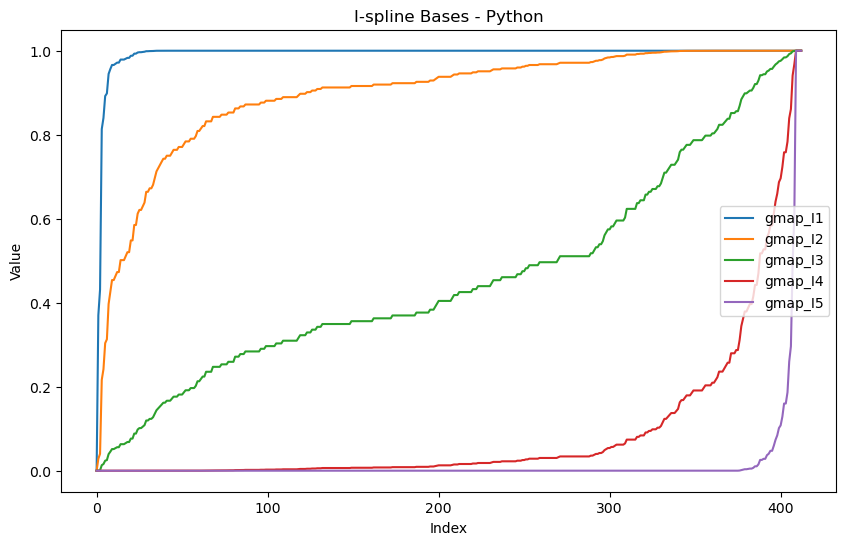

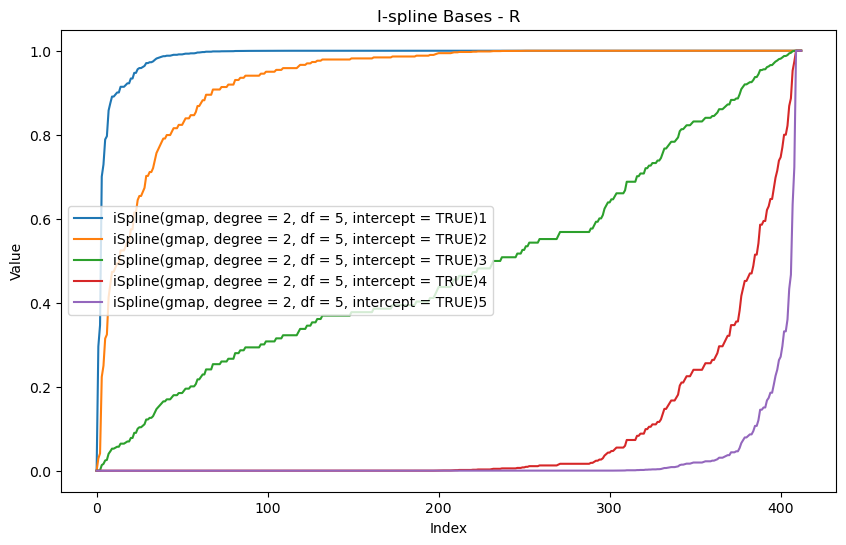

          gmap_I1     gmap_I2     gmap_I3     gmap_I4     gmap_I5  \
count  413.000000  413.000000  413.000000  413.000000  413.000000   
mean     0.992288    0.895549    0.459097    0.091178    0.017120   
std      0.065924    0.151361    0.247815    0.188973    0.107945   
min      0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    0.880927    0.296678    0.002628    0.000000   
50%      1.000000    0.937913    0.404280    0.012810    0.000000   
75%      1.000000    0.988150    0.602694    0.064953    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000   

       RFL_CONC_I1  RFL_CONC_I2  RFL_CONC_I3  RFL_CONC_I4  RFL_CONC_I5  ...  \
count   413.000000   413.000000   413.000000   413.000000   413.000000  ...   
mean      0.967369     0.835099     0.480038     0.154516     0.054947  ...   
std       0.124719     0.261116     0.310139     0.283292     0.188740  ...   
min       0.000000     0.000000     0.000000     0.000000     

,"iSpline(gmap, degree = 2, df = 5, intercept = TRUE)1","iSpline(gmap, degree = 2, df = 5, intercept = TRUE)2","iSpline(gmap, degree = 2, df = 5, intercept = TRUE)3","iSpline(gmap, degree = 2, df = 5, intercept = TRUE)4","iSpline(gmap, degree = 2, df = 5, intercept = TRUE)5","iSpline(RFL_CONC, degree = 2, df = 5, intercept = TRUE)1","iSpline(RFL_CONC, degree = 2, df = 5, intercept = TRUE)2","iSpline(RFL_CONC, degree = 2, df = 5, intercept = TRUE)3","iSpline(RFL_CONC, degree = 2, df = 5, intercept = TRUE)4","iSpline(RFL_CONC, degree = 2, df = 5, intercept = TRUE)5",...,"iSpline(SoilConductivitymSm, degree = 2, df = 5, intercept = TRUE)1","iSpline(SoilConductivitymSm, degree = 2, df = 5, intercept = TRUE)2","iSpline(SoilConductivitymSm, degree = 2, df = 5, intercept = TRUE)3","iSpline(SoilConductivitymSm, degree = 2, df = 5, intercept = TRUE)4","iSpline(SoilConductivitymSm, degree = 2, df = 5, intercept = TRUE)5","iSpline(SoilTotalNPercent, degree = 2, df = 5, intercept = TRUE)1","iSpline(SoilTotalNPercent, degree = 2, df = 5, intercept = TRUE)2","iSpline(SoilTotalNPercent, degree = 2, df = 5, intercept = TRUE)3","iSpline(SoilTotalNPercent, degree = 2, df = 5, intercept = TRUE)4","iSpline(SoilTotalNPercent, degree = 2, df = 5, intercept = TRUE)5"
count,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,...,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000
mean,0.986614,0.933090,0.487520,0.095594,0.029455,0.949904,0.852245,0.499493,0.151746,0.073433,...,0.940953,0.792976,0.345413,0.090798,0.020047,0.976147,0.830404,0.329975,0.087649,0.021788
std,0.074043,0.150630,0.257736,0.205947,0.121062,0.143619,0.266823,0.318562,0.295610,0.206864,...,0.167853,0.300650,0.306984,0.180159,0.097090,0.095219,0.241565,0.292797,0.190927,0.093921
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.999796,0.949969,0.307881,0.000000,0.000000,0.992712,0.830547,0.194488,0.000000,0.000000,...,0.997955,0.715631,0.077261,0.000000,0.000000,0.999030,0.708865,0.067380,0.000000,0.000000
50%,1.000000,0.994196,0.437456,0.000695,0.000000,1.000000,1.000000,0.589274,0.020736,0.000000,...,1.000000,0.961986,0.241703,0.002150,0.000000,1.000000,0.976252,0.252596,0.004106,0.000000
75%,1.000000,1.000000,0.667555,0.059385,0.000579,1.000000,1.000000,0.649410,0.045336,0.000136,...,1.000000,1.000000,0.607014,0.094509,0.000926,1.000000,1.000000,0.504496,0.052872,0.000088
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [89]:
import matplotlib.pyplot as plt

# Select the columns to plot
# Convert the numpy.ndarray to a pandas DataFrame
I_spline_bases_df = pd.DataFrame(I_spline_bases, columns=[f"{var}_I{j}" for var in env_var_names for j in range(1, df+1)])

# Select the columns to plot
columns_to_plot = I_spline_bases_df.columns[:5]

# Plot the data
plt.figure(figsize=(10, 6))
for column in columns_to_plot:
    sorted_values = np.sort(I_spline_bases_df[column])
    plt.plot(range(len(sorted_values)), sorted_values, label=column)
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('I-spline Bases - Python')
plt.show()

# Select the columns to plot
columns_to_plot = I_spline_bases_R.columns[:5]

# Plot the data
plt.figure(figsize=(10, 6))
for column in columns_to_plot:
    sorted_values = np.sort(I_spline_bases_R[column])
    plt.plot(range(len(sorted_values)), sorted_values, label=column)
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('I-spline Bases - R')
plt.show()

print(I_spline_bases_df.describe())
I_spline_bases_R.describe()


In [101]:
import matplotlib.pyplot as plt

# Select the columns to plot
columns_to_plot = I_spline_bases_R.columns[:5]

# Plot the data
plt.figure(figsize=(10, 6))
for column in columns_to_plot:
    sorted_values = np.sort(I_spline_bases[:, column_names.index(column)], axis=0)
    plt.plot(range(len(sorted_values)), sorted_values, label=column)
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('I-spline Bases')
plt.show()

ValueError: 'iSpline(gmap, degree = 2, df = 5, intercept = TRUE)1' is not in list

<Figure size 1000x600 with 0 Axes>

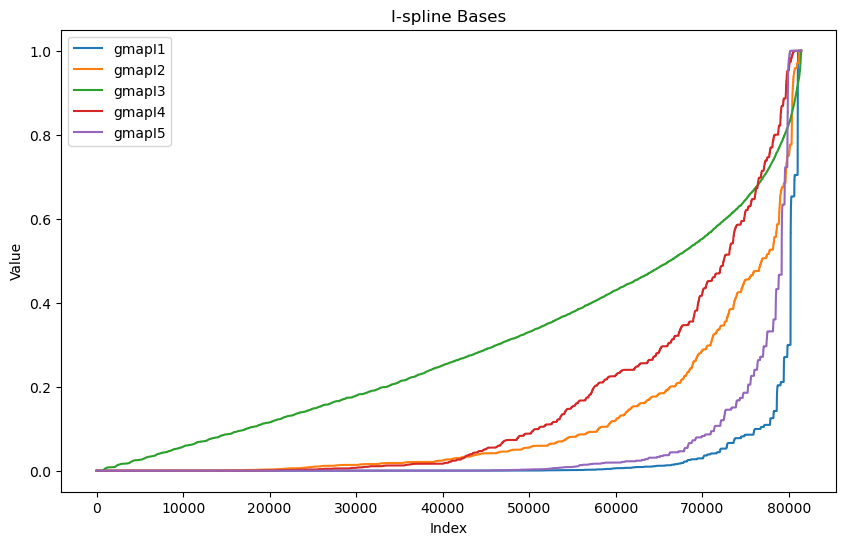

In [5]:
#------------------------------------------------------------------------
# Get initial values to speed up spGDMM fitting
#------------------------------------------------------------------------

# Fit linear model
lm_mod = LinearRegression(fit_intercept=True).fit(X_GDM, np.log(Z))

# Define objective function
objective = lambda params: np.sum((np.log(Z) - params[0] - X_GDM @ np.exp(params[1:(p+1)]))**2)

# Set up initial parameters, taking logs of positive and setting negative coefficients to -10
initial_params = np.concatenate([
    [0.3],  # Intercept, why chosen to be this?
    np.where(lm_mod.coef_ > 0, np.log(lm_mod.coef_), -10),  # Log coefficients greater than 0, and set those < 0 to -10
    #np.random.randn(ns)  # Random values for each site
])

optimized_params = minimize(objective, initial_params, method='BFGS').x

#------------------------------------------------------------------------
# Fix spatial range parameter (rho = 1 / phi) heuristically (can also estimate using the data, or even deep GP). 
# Setting up spatial correlation structure.
#------------------------------------------------------------------------

rho_fix = np.max(vec_distance) / 10
R_spat_mat = squareform(np.exp(- vec_distance / rho_fix))
#chol_R = np.linalg.cholesky(R_spat_mat).T
R_inv = np.linalg.inv(R_spat_mat)

#------------------------------------------------------------------------
# Define design matrix for a polynomial log-variance
#------------------------------------------------------------------------

# NOTE these features are not orthogonal as they were in the R implementation
X_sigma = PolynomialFeatures(degree=3, include_bias=True).fit_transform(vec_distance.reshape(-1, 1))
p_sigma = X_sigma.shape[1]


Proportion of zeros: 0.0
Proportion of ones: 0.08947368421052632


/tmp/ipykernel_206594/501244899.py:91: RuntimeWarning: invalid value encountered in log
  np.where(lm_mod.coef_ > 0, np.log(lm_mod.coef_), -10),  # Log coefficients greater than 0, and set those < 0 to -10


In [26]:

#------------------------------------------------------------------------
# Source nimble models -- Models 1-9 match those in paper
#------------------------------------------------------------------------

# Create constants for the model
constants = {
    'n': N,
    'p': p,
    'x': X_GDM,
}

# # Create data for the model
# data = {
#     'log_V': np.where(Z == 1, np.nan, np.log(Z)),
#     'censored': (Z == 1).astype(int),
#     'c': np.zeros(constants['n'])
# }

# # Create initial values for the model
# inits = {
#     'beta_0': optimized_params[0],
#     'log_beta': optimized_params[1:(p+1)],
#     'sig2_psi': 1,
#     'beta_sigma': np.array([-5, -20, 12, 2]),
#     'psi': optimized_params[(p+1):]
# }
'''
Implement the first model using PyMC. Provided parameters are for a specific site-pair.
    
    V ~ N(mu, sigma^2)
    mu = beta_0 + beta * h(||s[i] - s[j]||) + sum of the covariate distances

    Spatial Random Effects -    None
    Variance -                  sigma^2

    Parameters:
    X (ndarray): The feature matrix.
    p (int): The number of features.
    n (int): The number of observations.
    c (ndarray): The censoring values.
    log_V (ndarray): The log-transformed response variable.
    censored (ndarray): The censored observations.
'''
# CHECK IF THERE IS AN INTERCEPT AT THE BEGINNING OF OPTIMIZED PARAMS & X_GDM
# CHECK IF WE ARE USING PYMC ON THE ENTIRE X_GDM
beta_0_init = optimized_params[0]
log_beta_init =  optimized_params[1:(p+1)]
sig2_psi_init = 1
beta_sigma_init = np.array([-5, -20, 12, 2])
psi_init = optimized_params[(p+1):]

log_V = np.where(Z == 1, np.nan, np.log(Z))
censored = 1*(Z == 1)
c = np.zeros(N)

print(log_V.shape)

with pm.Model() as model:
        # Define the priors
        beta_0 = pm.Normal('beta_0', mu=0, sigma=10)
        beta = pm.Lognormal('beta', mu=0, sigma=10, shape=p)

        # Calculate the linear predictor
        linpred = pm.math.dot(X_GDM, beta)
        
        # Define the likelihood
        sigma2 = pm.InverseGamma('sigma2', alpha=1, beta=1)
        mu = beta_0 + linpred

        censored = pm.Bound(pm.Normal, lower=0)('censored', mu=mu, sigma=np.sqrt(sigma2), observed=c)

        log_V = pm.Normal('log_V', mu=mu, sigma=np.sqrt(sigma2), shape=n)

        # log_V_obs = pm.Normal('log_V_obs', mu=mu, sigma=pm.math.sqrt(sigma2), observed=log_V)
        
        # Sample from the posterior with progress bar enabled
        trace = pm.sample(1000, return_inferencedata=True, progressbar=True)


(190,)


/home/harold/miniconda3/envs/spGDMM/lib/python3.12/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in log_V_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta, sigma2, log_V_obs_unobserved]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 157 seconds.
/home/harold/miniconda3/envs/spGDMM/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/190

In [35]:
Z.shape

(190,)

In [14]:
import pymc as pm

# Check if pm.math is available
print(dir(pm.math))

# Example usage of pm.math.dot
import numpy as np

X = np.random.randn(100, 5)
beta = np.random.randn(5)

linpred = pm.math.dot(X, beta)
print(linpred)

['Apply', 'BatchedDiag', 'LogDet', 'Op', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'abs', 'and_', 'arccos', 'arccosh', 'arcsin', 'arcsinh', 'arctan', 'arctanh', 'batched_diag', 'block_diagonal', 'broadcast_to', 'cartesian', 'ceil', 'clip', 'concatenate', 'constant', 'cos', 'cosh', 'cumprod', 'cumsum', 'dot', 'eq', 'erf', 'erfc', 'erfcinv', 'erfinv', 'exp', 'expand_packed_triangular', 'flat_outer', 'flatten', 'flatten_list', 'floatX', 'floor', 'full', 'full_like', 'ge', 'gt', 'invlogit', 'invprobit', 'kron_diag', 'kron_dot', 'kron_matrix_op', 'kron_solve_lower', 'kron_solve_upper', 'kronecker', 'le', 'log', 'log1mexp', 'log1mexp_numpy', 'log1pexp', 'log_softmax', 'logaddexp', 'logbern', 'logdet', 'logdiffexp', 'logdiffexp_numpy', 'logit', 'logsumexp', 'lt', 'matmul', 'matrix_inverse', 'max', 'maximum', 'mean', 'min', 'minimum', 'neq', 'np', 'ones', 'ones_like', 'or_', 'partial', 'probit', 'prod', 'pt', 'pytensor'

In [27]:
import pymc as pm
print(pm.__version__)
from pymc import math

5.16.2
